In [1]:
%cd /home/tk/repos/erc/

/home/tk/repos/erc


In [2]:
ROOT_DIR = './multimodal-datasets/'
# model_checkpoint= '/home/tk/repos/erc/results/MELD/roberta-large/SEEDS/2021-05-08-19-57-31-speaker_mode-upper-num_past_utterances-1000-num_future_utterances-1000-batch_size-4-seed-4/checkpoint-9992/'
# model_checkpoint = '/home/tk/repos/erc/results/IEMOCAP/roberta-large/SEEDS/2021-05-08-16-15-19-speaker_mode-upper-num_past_utterances-1000-num_future_utterances-1000-batch_size-4-seed-2/checkpoint-5975/'
model_checkpoint = '/home/tk/repos/erc/results/IEMOCAP/roberta-large/SEEDS/2021-05-09-12-19-54-speaker_mode-upper-num_past_utterances-1000-num_future_utterances-0-batch_size-4-seed-4/checkpoint-5975/'

DATASET = model_checkpoint.split('/')[6]
params = model_checkpoint.split('/')[9]
speaker_mode = params.split('-')[7]
num_past_utterances = int(params.split('-')[9])
num_future_utterances = int(params.split('-')[11])
SEED = int(params.split('-')[-1])

DATASET, speaker_mode, num_past_utterances, num_future_utterances, SEED

('IEMOCAP', 'upper', 1000, 0, 4)

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from utils import get_num_classes, ErcTextDataset
import numpy as np
import matplotlib.pyplot as plt
NUM_CLASSES = get_num_classes(DATASET)
tokenizer = AutoTokenizer.from_pretrained(
    model_checkpoint, use_fast=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=NUM_CLASSES)

model.eval()
model.cpu()
ds_test = ErcTextDataset(DATASET=DATASET, SPLIT='test', speaker_mode=speaker_mode,
                         num_past_utterances=num_past_utterances, num_future_utterances=num_future_utterances,
                         model_checkpoint='roberta-large',
                         ROOT_DIR=ROOT_DIR, SEED=SEED)

# ds_train = ErcTextDataset(DATASET=DATASET, SPLIT='train', speaker_mode=speaker_mode,
#                          num_past_utterances=num_past_utterances, num_future_utterances=num_future_utterances,
#                          model_checkpoint='roberta-large',
#                          ROOT_DIR=ROOT_DIR, SEED=SEED)

# ds_val = ErcTextDataset(DATASET=DATASET, SPLIT='val', speaker_mode=speaker_mode,
#                          num_past_utterances=num_past_utterances, num_future_utterances=num_future_utterances,
#                          model_checkpoint='roberta-large',
#                          ROOT_DIR=ROOT_DIR, SEED=SEED)

2021-05-17 23:34:13.892 INFO utils - _load_utterance_ordered: every text file exists fine!
2021-05-17 23:34:13.893 INFO utils - _string2tokens: converting utterances into tokens ...
2021-05-17 23:34:13.894 INFO utils - _string2tokens: creating input utterance data ... 
100%|██████████| 31/31 [00:01<00:00, 21.85it/s]
2021-05-17 23:34:17.701 INFO utils - _create_input: number of truncated utterances: 1131


In [27]:
def get_random_sample(ds_test, tokenizer, idx=None, max_tokens=512):
    while True:
        if idx is None:
            idx_ = np.random.randint(0, len(ds_test))
        else:
            idx_ = idx
        random_sample = ds_test[idx_]
        input_ids, attention_mask, labelid = random_sample['input_ids'], random_sample['attention_mask'], random_sample['label']
        break
#         if len(input_ids) < max_tokens and labelid != 0:
#             break

    decoded = tokenizer.decode(input_ids)

    input_ids = torch.tensor(input_ids).view(-1, len(input_ids))
    attention_mask = torch.tensor(attention_mask).view(-1, len(attention_mask))
    labelid = torch.tensor(labelid).view(-1, 1)
    

    return idx_, input_ids, attention_mask, labelid, decoded

def return_coeffs(tokenizer, input_ids, attentions, BATCH_IDX=0, LAYER=-1, QUERY_TOKEN_IDX=0, annoying_char='Ġ'):
    tokens = tokenizer.convert_ids_to_tokens(input_ids[BATCH_IDX].tolist())
    QUERY_TOKEN = tokens[QUERY_TOKEN_IDX].split(annoying_char)[-1]

    coeffs = attentions[LAYER][BATCH_IDX].cpu().detach().numpy().sum(axis=0)[QUERY_TOKEN_IDX]
    coeffs /= coeffs.sum()
    
    idx_token_coeffs = [(idx, token.split(annoying_char)[-1], coeffs[idx]) for idx, token in enumerate(tokens)]
    
    assert len(coeffs) == len(tokens) == len(idx_token_coeffs)
    
    
    return QUERY_TOKEN, coeffs, tokens, idx_token_coeffs


In [87]:
import pprint
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

idx, input_ids, attention_mask, labelid, decoded = get_random_sample(ds_test, tokenizer, max_tokens=512)
pprint.pprint(f"{decoded}")
print()

outputs = model(**{'input_ids': input_ids, 'attention_mask': attention_mask}, labels=labelid, output_attentions=True, output_hidden_states=True)
attentions = outputs.attentions
pred = int(outputs.logits.argmax().numpy())
truth = int(labelid[0][0].numpy())

pprint.pprint(f"data_idx: {idx}")
pprint.pprint(f"pred: {ds_test.id2emotion[pred]}")
pprint.pprint(f"truth: {ds_test.id2emotion[truth]}")
pprint.pprint(f"number of tokens in the input: {input_ids.shape[1]}")
print()

("<s>ELIZABETH: You're the only one I know who loves his parents. WILLIAM: I "
 "know.  It's going out of style isn't it? ELIZABETH: No, it's good. "
 "ELIZABETH: It's so lovely here.  The air is sweet. WILLIAM: So you're not "
 "sorry you came? ELIZABETH: No.  But I'm not going to stay. WILLIAM: Why? "
 'ELIZABETH: Well your mother has much as told me to leave. WILLIAM: Well-- '
 "ELIZABETH: Well, you saw that! And you.  You've been- WILLIAM: What? "
 'ELIZABETH: Well sort of embarrassed soon as I came.</s></s>WILLIAM: Well the '
 'plan was to kind of sneak up on you over a period of a week or so.  But uh- '
 "they take it for granted that we're all set.</s>")

'data_idx: 343'
'pred: neutral'
'truth: happiness'
'number of tokens in the input: 202'



In [88]:
decoded

"<s>ELIZABETH: You're the only one I know who loves his parents. WILLIAM: I know.  It's going out of style isn't it? ELIZABETH: No, it's good. ELIZABETH: It's so lovely here.  The air is sweet. WILLIAM: So you're not sorry you came? ELIZABETH: No.  But I'm not going to stay. WILLIAM: Why? ELIZABETH: Well your mother has much as told me to leave. WILLIAM: Well-- ELIZABETH: Well, you saw that! And you.  You've been- WILLIAM: What? ELIZABETH: Well sort of embarrassed soon as I came.</s></s>WILLIAM: Well the plan was to kind of sneak up on you over a period of a week or so.  But uh- they take it for granted that we're all set.</s>"

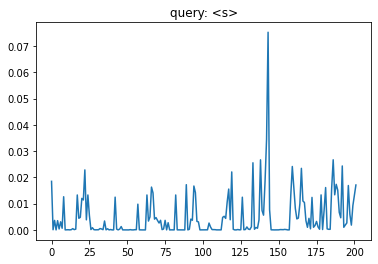

[(0, '<s>', 0.018490328), (1, 'EL', 7.087463e-05), (2, 'IZ', 0.0036216779), (3, 'AB', 9.131049e-06), (4, 'ETH', 0.003521988), (5, ':', 0.0003648079), (6, 'You', 0.0030940827), (7, "'re", 0.0006318671), (8, 'the', 0.012629616), (9, 'only', 2.0211244e-05), (10, 'one', 5.913559e-05), (11, 'I', 6.8649846e-05), (12, 'know', 1.880975e-05), (13, 'who', 8.237419e-05), (14, 'loves', 0.00048399763), (15, 'his', 0.00011217632), (16, 'parents', 0.0003000183), (17, '.', 0.0132984985), (18, 'WILL', 0.004431148), (19, 'I', 0.004793599), (20, 'AM', 0.012002601), (21, ':', 0.011403312), (22, 'I', 0.022841105), (23, 'know', 0.0038326092), (24, '.', 0.013298508), (25, '', 0.0054932702), (26, 'It', 0.00014509213), (27, "'s", 0.00083310524), (28, 'going', 8.850363e-05), (29, 'out', 3.545094e-05), (30, 'of', 3.2490403e-05), (31, 'style', 6.3238636e-05), (32, 'isn', 0.0005255854), (33, "'t", 0.0003637756), (34, 'it', 9.501522e-05), (35, '?', 0.003393034), (36, 'EL', 2.8172273e-05), (37, 'IZ', 0.0004412576), 

In [89]:
QUERY_TOKEN, coeffs, tokens, idx_token_coeffs = return_coeffs(tokenizer, input_ids, attentions, LAYER=-1, QUERY_TOKEN_IDX=0)

plt.figure()
plt.plot(coeffs);
plt.title(f'query: {QUERY_TOKEN}')
plt.show()

print(idx_token_coeffs)
print()

top_10 = sorted(idx_token_coeffs, key=lambda x:-x[2])[:10]
print(top_10)

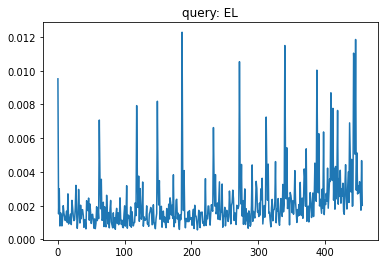

[(0, '<s>', 0.009518345), (1, 'W', 0.0015158709), (2, 'ILL', 0.003002666), (3, 'I', 0.00079906575), (4, 'AM', 0.0015781951), (5, ':', 0.0014044514), (6, 'I', 0.0008029061), (7, 'don', 0.0012150394), (8, "'t", 0.0020034947), (9, 'care', 0.0015642853), (10, 'what', 0.001330332), (11, 'you', 0.0011223308), (12, 'do', 0.001359587), (13, '.', 0.0016805531), (14, '', 0.0010125607), (15, 'See', 0.0027025985), (16, ',', 0.0009157068), (17, 'you', 0.0010617579), (18, 'could', 0.0013141251), (19, 'paint', 0.0015077016), (20, 'your', 0.0008832222), (21, 'body', 0.0023187026), (22, 'bright', 0.0018949977), (23, 'green', 0.0013917314), (24, 'and', 0.0011168647), (25, 'and', 0.0011702221), (26, 'run', 0.0018754338), (27, 'naked', 0.0032058253), (28, 'through', 0.0015592488), (29, 'the', 0.00065928086), (30, 'Place', 0.0012507546), (31, 'Vend', 0.0029668831), (32, 'ome', 0.0018342098), (33, 'and', 0.0009764782), (34, 'run', 0.002030901), (35, 'with', 0.0012309302), (36, 'every', 0.0017645716), (37, '

In [60]:
QUERY_TOKEN, coeffs, tokens, idx_token_coeffs = return_coeffs(tokenizer, input_ids, attentions, LAYER=0, QUERY_TOKEN_IDX=443)

plt.figure()
plt.plot(coeffs);
plt.title(f'query: {QUERY_TOKEN}')
plt.show()

print(idx_token_coeffs)
print()

top_10 = sorted(idx_token_coeffs, key=lambda x:-x[2])[:10]
print(top_10)